In [17]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import pandas as pd
import pathlib

In [18]:
data_dir = pathlib.Path('data/train/').with_suffix('')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

28709


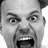

In [19]:
angry = list(data_dir.glob('angry/*'))
disgust = list(data_dir.glob('disgust/*'))
fear = list(data_dir.glob('fear/*'))
happy = list(data_dir.glob('happy/*'))
neutral = list(data_dir.glob('neutral/*'))
sad = list(data_dir.glob('sad/*'))
surprise = list(data_dir.glob('surprise/*'))

PIL.Image.open(str(angry[0]))
# PIL.Image.open(str(fear[0]))

In [20]:
batch_size = 32
img_height = 224
img_width = 224

In [ ]:
raw_train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=None,
  color_mode='grayscale')

raw_val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=None,
  color_mode='grayscale')


Found 28709 files belonging to 7 classes.
Using 22968 files for training.
Found 28709 files belonging to 7 classes.
Using 5741 files for validation.


In [22]:
# Save class names for later use
import json

class_names = raw_train_ds.class_names
print(class_names)

with open('class_names.json', 'w') as f:
    json.dump(class_names, f)

# To load files
def load_class_names():
    with open('class_names.json', 'r') as f:
        return json.load(f)
    
num_classes = len(class_names)
    
# Example usage : predictd_class_name = class_names[predicted_index]

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']


In [23]:
# Normalization is made in the layers - This code is therefore useless
# normalization_layer = tf.keras.layers.Rescaling(1./255)
# normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [ ]:
# Optimization and preprocessing
# ImageNet needs input in three channels, because it was trained on RGB images. This is why we convert the grayscale images to RGB by repeating the single channel three times.
# Even if the images are already grayscaled in the dataset, this conversion ensures that there is three channels with the same values to prevent any noise.
def convert_grayscale_to_rgb(image, label):
    image = tf.image.grayscale_to_rgb(image)
    return image, label

# Optimization
AUTOTUNE = tf.data.AUTOTUNE
train_ds = raw_train_ds
train_ds = train_ds.shuffle(buffer_size=1000)

# Convert the whole dataset
train_ds = train_ds.map(convert_grayscale_to_rgb, num_parallel_calls=AUTOTUNE)

# Cache & Batch & Prefetch
train_ds = train_ds.cache(filename='my_training_cache')
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

val_ds = raw_val_ds.map(convert_grayscale_to_rgb, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.cache()
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

In [25]:
import numpy as np

# 3. Create a dictionary to map class names to their integer index
class_indices = {name: i for i, name in enumerate(class_names)}

# 4. Count the number of images in each class directory
class_counts = {name: len(list(data_dir.joinpath(name).glob('*.jpg'))) for name in class_names}
total_samples = sum(class_counts.values())
print(f"Class counts: {class_counts}")

# 5. Calculate the class weights manually
class_weight_dict = {}
for name, count in class_counts.items():
    weight = total_samples / (num_classes * count)
    class_index = class_indices[name]
    class_weight_dict[class_index] = weight

print("Calculated Class Weight Dictionary:", class_weight_dict)

Class counts: {'angry': 3995, 'disgust': 436, 'fear': 4097, 'happy': 7215, 'neutral': 4965, 'sad': 4830, 'surprise': 3171}
Calculated Class Weight Dictionary: {0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [26]:
# Important - Set weights as the dataset is imbalanced
# from sklearn.utils import class_weight

# train_labels = []
# for images, labels in train_ds:
#     train_labels.extend(labels.numpy())
#     print(labels.numpy())

# class_weights = class_weight.compute_class_weight(
#     class_weight = "balanced",
#     classes = np.unique(train_labels),
#     y = train_labels
# )

# class_weight_dict = dict(enumerate(class_weights))

# print("Class Weight Dictionary:", class_weight_dict)

In [27]:
# # Ancient code for training from scratch - complete sequential without any transfer learning
# num_classes = len(train_ds.class_names)

# model = tf.keras.Sequential([
#   tf.keras.layers.Rescaling(1./255),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Conv2D(32, 3, activation='relu'),
#   tf.keras.layers.MaxPooling2D(),
#   tf.keras.layers.Flatten(),
#   tf.keras.layers.Dense(128, activation='relu'),
#   tf.keras.layers.Dense(num_classes)
# ])

# model.compile(
#   optimizer='adam',
#   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#   metrics=['accuracy'])

In [ ]:
num_classes = len(class_names)

# Data augmentation
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.RandomZoom(0.2),
  tf.keras.layers.RandomContrast(0.2),
  tf.keras.layers.RandomBrightness(0.2)
], name="data_augmentation")

In [30]:
# Setting up MobileNetV2 as base model
base_model = tf.keras.applications.MobileNetV2(
    input_shape = (img_width, img_height, 3), # 3 for RGB channels
    include_top = False,
    weights = "imagenet"
)

base_model.trainable = False

In [ ]:
# Creating the model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3)), # Simple definition of input shape
    data_augmentation,
    tf.keras.layers.Rescaling(1./127.5, offset=-1), # MobileNetV2 needs inputs in the range [-1, 1]
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(num_classes, )
])

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         8,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,266,951 (8.65 MB)

 Trainable params: 8,967 (35.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
# Model training
model_path = 'best_model.keras'
# Implement early stopping
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

# Save model periodically
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=model_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

# Add this callback to your list
lr_scheduler_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2, # Reduce LR by a factor of 5 (1 * 0.2)
    patience=2, # Reduce LR if no improvement for 2 epochs
    verbose=1,
    min_lr=1e-7 # Don't let the LR get ridiculously small
)

# Training
if os.path.exists(model_path):
  # model = model.load_weights(model_path)
  # print("Loaded model weights from", model_path)
  print("Base model exists, skipping to fine-tuning.")
else:
  print("No model weights found at", model_path)
  print("Starting training from scratch.")
  history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    class_weight=class_weight_dict,
    callbacks=[early_stopping_callback, model_checkpoint_callback, lr_scheduler_callback]
  )

Epoch 1/50


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "Conv1" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 224, 224, 1)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 224, 224, 1), dtype=float32)
  • training=True
  • mask=None
  • kwargs=<class 'inspect._empty'>

In [ ]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

print("\n--- Starting Phase 2: Fine-tuning the entire model ---")
# --- 1. Define Parameters (must match your original training setup) ---
# You still need to define these so the script knows how to handle the data.
# Assuming train_ds and val_ds are already created and prepared as before.
base_learning_rate = 0.0001
fine_tune_learning_rate = base_learning_rate / 10


# # --- 2. Load Your Previously Trained Model ---
ancient_fine_tuned_path = 'fine_tuned_model.keras'
print(f"Loading model from '{ancient_fine_tuned_path}' for fine-tuning...")
# Keras is smart. When it loads the model, it also loads the architecture,
# including the base_model inside.
model = tf.keras.models.load_model(ancient_fine_tuned_path)


# --- 3. Prepare the Model for Fine-Tuning ---
# We need to "reach inside" the loaded model to unfreeze the base_model.

# First, get a reference to the base model layer. Keras models have a .layers attribute.
# The base_model is usually the 4th layer in our Sequential model:
# [Input, Augmentation, Rescaling, **base_model**, GAP, Dropout, Dense]
base_model = model.layers[2]
base_model.trainable = True # Unfreeze the base model

# Let's see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Freeze the bottom layers and fine-tune the top ones
fine_tune_at = 80
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False


# --- 4. Re-compile the Model with the Fine-Tuning Learning Rate ---
# This is a CRITICAL step. The loaded model has the old optimizer state.
# We must compile it again with the new, lower learning rate.
model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=fine_tune_learning_rate),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy']
)

# Let's check the trainable parameters again to confirm our changes worked
model.summary()


fine_tuned_path = 'fine_tuned_model.keras'

model_checkpoint_callback = ModelCheckpoint(
    filepath=fine_tuned_path, # Save to the same file
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
)

# --- 6. Continue Training (Perform Phase 2) ---
print("\n--- Starting Phase 2: Fine-tuning the entire model ---")

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=75,
    class_weight=class_weight_dict,   # You still need your class_weight_dict
    callbacks=[early_stopping_callback, model_checkpoint_callback, lr_scheduler_callback]
)

In [ ]:
sample_img_path = fear[20]
PIL.Image.open(str(sample_img_path))

In [ ]:

img = tf.keras.utils.load_img(
    str(sample_img_path),
    target_size=(img_width, img_height),
    color_mode="grayscale"
)

# img_array = np.array(img)
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, 0)  # add batch dimension

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

predicted_index = np.argmax(score)
predicted_class_name = train_ds.class_names[predicted_index]

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(predicted_class_name, 100 * np.max(score))
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
This image most likely belongs to fear with a 81.92 percent confidence.
